## Astronauts. ATOM Analysis

In [1]:
import pandas as pd
import numpy as np
import json
from math import log10

from src.utils_bigquery import create_table_from_df, drop_table
from src.utils_charts import grade_boundaries_analysis
from config import COSMOS_DATASET_NAME, COSMOS_DISTRIBUTION_TABLE_NAME

DROP_TABLES = True
CREATE_TABLES = True

### Load Cosmos
You can get Cosmos snapshot from Cosmos Hub by the command:

```bash
gaiad export --for-zero-height --height=<height block> > cosmos_genesis_snapshot.json
```

The snapshot that was used is [here](https://ipfs.io/ipfs/QmcubEyzTa5nJCjkt8Lef4DP8Nk81tJxR2C4XRCHvZp5yb)

In [2]:
with open("data/cosmos_genesis_snapshot.json") as f:
    cosmos_genesis_snapshot = json.load(f)

### Get Balances from the Snapshot

In [3]:
def get_atoms(coins):
    for coin in coins:
        if coin['denom']=='uatom':
            return float(coin['amount'])/1e6
    return 0

# Get Available balances
available_source_df = pd.DataFrame(cosmos_genesis_snapshot["app_state"]['bank']['balances'])
available_source_df.loc[:, 'available_atom'] = available_source_df.coins.map(get_atoms)
available_source_df = available_source_df[available_source_df.available_atom != 0]
available_source_df['address'] = available_source_df['address'].map(lambda x: x.lower())
available_df = available_source_df.groupby('address')['available_atom'].agg(sum).reset_index()

# Get Delegated balances
delegated_source_df = \
    pd.DataFrame(cosmos_genesis_snapshot["app_state"]['staking']['delegations'])[['delegator_address', 'shares']] \
        .rename(columns={'delegator_address': 'address'})
delegated_source_df['address'] = delegated_source_df['address'].map(lambda x: x.lower())
delegated_source_df.loc[:, 'delegated_atom'] = delegated_source_df['shares'].map(lambda x: float(x)/1e6)
delegated_df = delegated_source_df.groupby('address')['delegated_atom'].agg(sum).reset_index()

# Get Unbonding delegations
unbonding_delegations = \
    pd.DataFrame([[unbonding_delegation['delegator_address'].lower(), sum([float(entry['balance'])
                  for entry in unbonding_delegation['entries']])/1e6]
                  for unbonding_delegation in cosmos_genesis_snapshot["app_state"]['staking']['unbonding_delegations']],
                 columns=['address', 'unbonding_atom']).groupby('address')['unbonding_atom'].agg(sum).reset_index()

# Merge Available and Delegated balances
balances_df = \
    available_df[['address', 'available_atom']].merge(
        delegated_df[['address', 'delegated_atom']],
        how='outer',
        on='address'
    ).merge(
        unbonding_delegations[['address', 'unbonding_atom']],
        how='outer',
        on='address'
    ).fillna(0)
balances_df.loc[:, 'balance_atom'] = balances_df[['available_atom', 'delegated_atom', 'unbonding_atom']].sum(axis=1)
balances_df.loc[:, 'balance_atom_rounded'] = balances_df.balance_atom.map(lambda x: round(x + 0.05, 1))

balances_agg_df = balances_df.groupby('balance_atom_rounded')['address'].agg([('number_of_addresses', np.count_nonzero)]).reset_index()

### Analysis of Grade Boundaries. Atom Owners

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,0.1 < ATOM Balance <= 215.0,112146,89.0
2,215.0 < ATOM Balance <= 8633.0,12615,10.0
3,8633.0 < ATOM Balance,1261,1.0


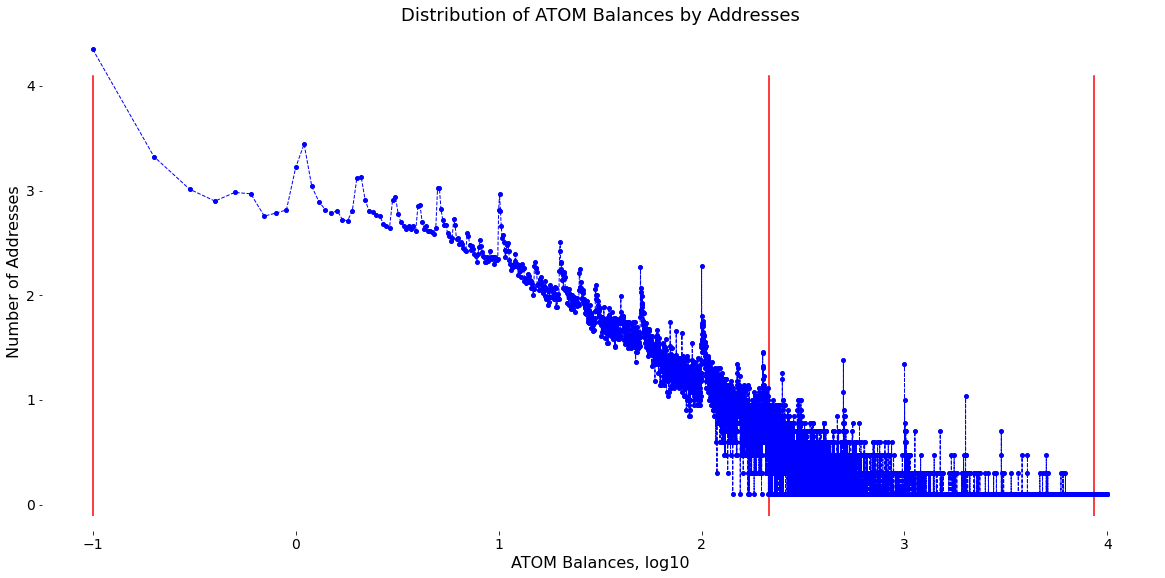

In [4]:
atom_owners_boundary =\
    grade_boundaries_analysis(
        distribution_df=balances_agg_df,
        value_column='balance_atom_rounded',
        address_column='number_of_addresses',
        address_chart_label='Number of Addresses',
        value_chart_label='ATOM Balances, log10',
        value_name='ATOM Balance',
        value_transform_func=lambda x: log10(x) if x > 0 else -1.5,
        chart_title='Distribution of ATOM Balances by Addresses',
        max_show_value=10000,
        initial_boundary=0.1,
        level_line_shift=0,
        boundary_round=0)

### Distribution Rule. Atom Owners

<table style="text-align: center">
    <thead>
        <tr>
            <th rowspan=2> </th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> ATOM Balance </td>
            <td> > 0.1 ATOM </td>
            <td> > 215 ATOM </td>
            <td> > 8,633 ATOM </td>
        </tr>
    </tbody>
</table>

### Create Distribution Table

In [5]:
def set_grade(x):
    if x > atom_owners_boundary[2]:
        return 3
    elif x > atom_owners_boundary[1]:
        return 2
    elif x > atom_owners_boundary[0]:
        return 1
    return None

balances_df.loc[:,'grade'] = balances_df['balance_atom'].map(set_grade)

In [6]:
if CREATE_TABLES:
    create_table_from_df(source_df=balances_df[['address', 'grade', 'balance_atom']],
                         table_name=COSMOS_DISTRIBUTION_TABLE_NAME,
                         dataset_name=COSMOS_DATASET_NAME,
                         drop_existing_table=DROP_TABLES)
elif DROP_TABLES:
    drop_table(table_name=COSMOS_DISTRIBUTION_TABLE_NAME,
               dataset_name=COSMOS_DATASET_NAME)

Table cosmos:cosmos_distribution has been deleted.
Table cosmos:cosmos_distribution has been created.
